In [ ]:
%matplotlib inline


Neural Transfer Using PyTorch
=============================


**Author**: `Alexis Jacq <https://alexis-jacq.github.io>`_
 
**Edited by**: `Winston Herring <https://github.com/winston6>`_

Introduction
------------

This tutorial explains how to implement the `Neural-Style algorithm <https://arxiv.org/abs/1508.06576>`__
developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and
reproduce it with a new artistic style. The algorithm takes three images,
an input image, a content-image, and a style-image, and changes the input 
to resemble the content of the content-image and the artistic style of the style-image.

 
.. figure:: /_static/img/neural-style/neuralstyle.png
   :alt: content1



Underlying Principle
--------------------

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

Importing Packages and Selecting a Device
-----------------------------------------
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)



In [4]:
!pip3 install torch torchvision torchaudio

ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

ModuleNotFoundError: No module named 'torch'

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading the Images
------------------

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable to sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 


.. Note::
    Here are links to download the images required to run the tutorial:
    `picasso.jpg <https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg>`__ and
    `dancing.jpg <https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg>`__.
    Download these two images and add them to a directory
    with name ``images`` in your current working directory.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/drive/MyDrive/fotos_projeto/farol_2.jpg")
content_img = image_loader("/content/drive/MyDrive/fotos_projeto/haversters.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.



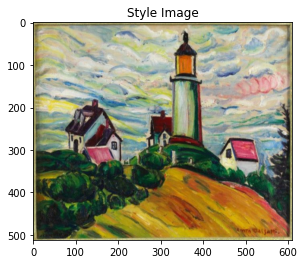

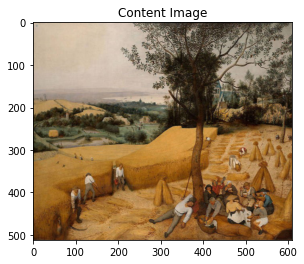

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Loss Functions
--------------
Content Loss
~~~~~~~~~~~~

The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.




In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

.. Note::
   **Important detail**: although this module is named ``ContentLoss``, it
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss function, you have to create a PyTorch autograd function 
   to recompute/implement the gradient manually in the ``backward``
   method.



Style Loss
~~~~~~~~~~

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.




In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Importing the Model
-------------------

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




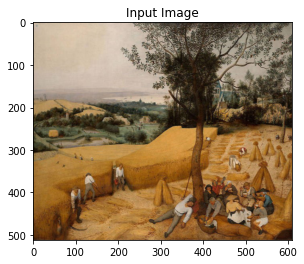

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Gradient Descent
----------------

As Leon Gatys, the author of the algorithm, suggested `here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 21.750572 Content Loss: 11.171461

run [100]:
Style Loss : 6.581758 Content Loss: 8.653158

run [150]:
Style Loss : 3.883195 Content Loss: 7.258227

run [200]:
Style Loss : 2.477480 Content Loss: 6.697134

run [250]:
Style Loss : 1.640517 Content Loss: 6.345532

run [300]:
Style Loss : 1.243041 Content Loss: 6.080247

run [350]:
Style Loss : 1.055193 Content Loss: 5.891073

run [400]:
Style Loss : 0.913445 Content Loss: 5.779692

run [450]:
Style Loss : 0.797433 Content Loss: 5.705588

run [500]:
Style Loss : 0.710436 Content Loss: 5.655165

run [550]:
Style Loss : 0.646692 Content Loss: 5.617217

run [600]:
Style Loss : 0.608335 Content Loss: 5.585033

run [650]:
Style Loss : 0.579952 Content Loss: 5.555887

run [700]:
Style Loss : 0.556607 Content Loss: 5.535458

run [750]:
Style Loss : 0.539035 Content Loss: 5.516197

run [800]:
Style Loss : 0.528979 Content Loss: 5.497043

run [850]:
Style Loss : 0.512406 Content Loss: 5.479691

run [900]:
Style Loss : 0.5028

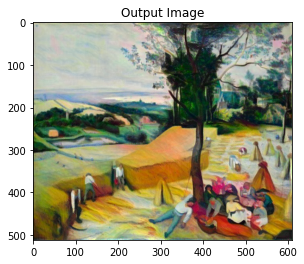

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

russa_monalisa

Building the style transfer model..
Optimizing..
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
run [50]:
Style Loss : 102.707901 Content Loss: 22.285728

run [100]:
Style Loss : 32.990200 Content Loss: 20.111176

run [150]:
Style Loss : 15.150913 Content Loss: 17.068859

run [200]:
Style Loss : 9.671658 Content Loss: 14.462422

run [250]:
Style Loss : 7.583469 Content Loss: 12.545250

run [300]:
Style Loss : 6.151268 Content Loss: 11.208881

run [350]:
Style Loss : 4.837260 Content Loss: 10.304095

run [400]:
Style Loss : 3.658995 Content Loss: 9.652554

run [450]:
Style Loss : 2.617989 Content Loss: 9.165062

run [500]:
Style Loss : 1.802531 Content Loss: 8.721892

run [550]:
Style Loss : 1.243259 Content Loss: 8.333261

run [600]:
Style Loss : 0.876256 Content Loss: 7.957297

run [650]:
Style Loss : 0.657478 Content Loss: 7.644142

run [700]:
Style Loss : 0.522282 Content Loss: 7.364226

run [750]:
Style Loss : 0.444980 Content Loss: 7.126584

run [800]:
Style Loss : 0.393072 Content Loss: 6.929964

run [850]:
Style Loss : 0.353391 Content Loss: 6.769225

run [900]:
Style Loss : 0.338138 Content Loss: 6.615210

run [950]:
Style Loss : 0.309906 Content Loss: 6.497489

run [1000]:
Style Loss : 0.301140 Content Loss: 6.397377

a_estudante_russa2.jpg (Anita Malfatti) e O Grito3.jpg

Optimizing..
run [50]:
Style Loss : 96.187477 Content Loss: 21.735889

run [100]:
Style Loss : 39.520721 Content Loss: 22.004410

run [150]:
Style Loss : 24.387579 Content Loss: 20.879868

run [200]:
Style Loss : 17.011673 Content Loss: 19.726820

run [250]:
Style Loss : 12.324890 Content Loss: 18.638117

run [300]:
Style Loss : 9.344831 Content Loss: 17.815887

run [350]:
Style Loss : 7.428841 Content Loss: 17.254166

run [400]:
Style Loss : 6.233727 Content Loss: 16.773680

run [450]:
Style Loss : 5.511491 Content Loss: 16.352442

run [500]:
Style Loss : 5.079020 Content Loss: 16.049110

a_estudantge_russa e Charlotte.jpg (CHARLOTTE SALOMON)

run [50]:
Style Loss : 88.167870 Content Loss: 18.371166

run [100]:
Style Loss : 41.443764 Content Loss: 18.848152

run [150]:
Style Loss : 26.873299 Content Loss: 18.374762

run [200]:
Style Loss : 19.365208 Content Loss: 17.699259

run [250]:
Style Loss : 14.227033 Content Loss: 17.165117

run [300]:
Style Loss : 10.863372 Content Loss: 16.786192

run [350]:
Style Loss : 8.534709 Content Loss: 16.513229

run [400]:
Style Loss : 6.900444 Content Loss: 16.310705

run [450]:
Style Loss : 5.841520 Content Loss: 16.111197

run [500]:
Style Loss : 5.112540 Content Loss: 15.900971

a_estudante_russa e Edvard (Edvard Munch)

Optimizing..
run [50]:
Style Loss : 35.751984 Content Loss: 12.969469

run [100]:
Style Loss : 12.532464 Content Loss: 13.172691

run [150]:
Style Loss : 7.630995 Content Loss: 12.588438

run [200]:
Style Loss : 5.722372 Content Loss: 12.067815

run [250]:
Style Loss : 4.783376 Content Loss: 11.685967

run [300]:
Style Loss : 4.269047 Content Loss: 11.415176

run [350]:
Style Loss : 3.916145 Content Loss: 11.223526

run [400]:
Style Loss : 3.661427 Content Loss: 11.094266

run [450]:
Style Loss : 3.488573 Content Loss: 10.975902

run [500]:
Style Loss : 3.360205 Content Loss: 10.890955

a_estudante_russa e Lady_vinci.jpg (Leonardo da Vinci)

Optimizing..
run [50]:
Style Loss : 44.542377 Content Loss: 15.552444

run [100]:
Style Loss : 15.970545 Content Loss: 15.577825

run [150]:
Style Loss : 8.476819 Content Loss: 15.302116

run [200]:
Style Loss : 5.749892 Content Loss: 14.924519

run [250]:
Style Loss : 4.684924 Content Loss: 14.516412

run [300]:
Style Loss : 4.098478 Content Loss: 14.185448

run [350]:
Style Loss : 3.745340 Content Loss: 13.922931

run [400]:
Style Loss : 3.503768 Content Loss: 13.729112

run [450]:
Style Loss : 3.333095 Content Loss: 13.563644

run [500]:
Style Loss : 3.210734 Content Loss: 13.415939

farol + noite estrelada

run [50]:
Style Loss : 39.932018 Content Loss: 15.900162

run [100]:
Style Loss : 17.640690 Content Loss: 11.376262

run [150]:
Style Loss : 8.744036 Content Loss: 9.196686

run [200]:
Style Loss : 5.974237 Content Loss: 7.948216

run [250]:
Style Loss : 4.519379 Content Loss: 7.226135

run [300]:
Style Loss : 3.627354 Content Loss: 6.791594

run [350]:
Style Loss : 2.882492 Content Loss: 6.552474

run [400]:
Style Loss : 2.223028 Content Loss: 6.457357

run [450]:
Style Loss : 1.695480 Content Loss: 6.406969

run [500]:
Style Loss : 1.327869 Content Loss: 6.325772

run [550]:
Style Loss : 1.111486 Content Loss: 6.217979

run [600]:
Style Loss : 0.983198 Content Loss: 6.110507

run [650]:
Style Loss : 0.880202 Content Loss: 6.013613

run [700]:
Style Loss : 0.817106 Content Loss: 5.924264

run [750]:
Style Loss : 0.775889 Content Loss: 5.843755

run [800]:
Style Loss : 0.734530 Content Loss: 5.781452

run [850]:
Style Loss : 0.711365 Content Loss: 5.733307

run [900]:
Style Loss : 0.689946 Content Loss: 5.690724

abaporu + venus

run [50]:
Style Loss : 205.315399 Content Loss: 13.078865

run [100]:
Style Loss : 82.463966 Content Loss: 12.660673

run [150]:
Style Loss : 32.410717 Content Loss: 12.063015

run [200]:
Style Loss : 12.064642 Content Loss: 11.173748

run [250]:
Style Loss : 6.568167 Content Loss: 10.638333

run [300]:
Style Loss : 3.973641 Content Loss: 9.799039

run [350]:
Style Loss : 2.891820 Content Loss: 9.068057

run [400]:
Style Loss : 2.344884 Content Loss: 8.640934

run [450]:
Style Loss : 1.983143 Content Loss: 8.363498

run [500]:
Style Loss : 1.714506 Content Loss: 8.165682

run [550]:
Style Loss : 1.512524 Content Loss: 8.009609

run [600]:
Style Loss : 1.367151 Content Loss: 7.869980

run [650]:
Style Loss : 1.258123 Content Loss: 7.751086

run [700]:
Style Loss : 1.178510 Content Loss: 7.664890

run [750]:
Style Loss : 1.129703 Content Loss: 7.609597

run [800]:
Style Loss : 1.078082 Content Loss: 7.538847

run [850]:
Style Loss : 1.038763 Content Loss: 7.482952

run [900]:
Style Loss : 1.012130 Content Loss: 7.451166

run [50]:
Style Loss : 136.985458 Content Loss: 16.495853

run [100]:
Style Loss : 37.741280 Content Loss: 14.568241

run [150]:
Style Loss : 19.003056 Content Loss: 12.261152

run [200]:
Style Loss : 9.892817 Content Loss: 10.390936

run [250]:
Style Loss : 5.010206 Content Loss: 8.961771

run [300]:
Style Loss : 2.771055 Content Loss: 7.851966

run [350]:
Style Loss : 1.791012 Content Loss: 7.016572

run [400]:
Style Loss : 1.267575 Content Loss: 6.465877

run [450]:
Style Loss : 0.989815 Content Loss: 6.135038

run [500]:
Style Loss : 0.835813 Content Loss: 5.912101

run [550]:
Style Loss : 0.741095 Content Loss: 5.752900

run [600]:
Style Loss : 0.681921 Content Loss: 5.647140

run [650]:
Style Loss : 0.645496 Content Loss: 5.566124

run [700]:
Style Loss : 0.609758 Content Loss: 5.512381

run [750]:
Style Loss : 0.591281 Content Loss: 5.467105

run [800]:
Style Loss : 0.572804 Content Loss: 5.441266

run [850]:
Style Loss : 0.563884 Content Loss: 5.421470

run [900]:
Style Loss : 0.561365 Content Loss: 5.421825